In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import fetch_openml

In [4]:
####DATA PREP####
#################

match_data = pd.read_csv('/Users/jon/Documents/fpl_points_prediction/ERD/tables/match_data.csv', delimiter=";", index_col=False)
player_match_data = pd.read_csv('/Users/jon/Documents/fpl_points_prediction/ERD/tables/player_match_data_withid.csv', delimiter=";", index_col=False)

#Merge main two tables
merged_data = player_match_data.merge(match_data, left_on='match_id', right_on='match_id', how='outer')
merged_data = merged_data.drop('value', axis=1)
merged_data = merged_data.drop('own_goals', axis=1) #Variation isn't large enough 104
merged_data = merged_data.drop('red_cards', axis=1) #Variation isn't large enough 111
merged_data = merged_data.drop('npxG', axis=1) #not using npg
merged_data = merged_data.drop('player_match_id', axis=1)

#Turning 'home' and 'away' into players team and opponent team for analysis
merged_data['p_team_spi'] = merged_data.apply(lambda row: row.h_team_spi if row.was_home == 1 else row.a_team_spi, axis=1)
merged_data['oppn_spi'] = merged_data.apply(lambda row: row.a_team_spi if row.was_home == 1 else row.h_team_spi, axis=1)
merged_data['prob_p_team_win'] = merged_data.apply(lambda row: row.prob_h_win if row.was_home == 1 else row.prob_a_win, axis=1)
merged_data['prob_oppn_win'] = merged_data.apply(lambda row: row.prob_a_win if row.was_home == 1 else row.prob_h_win, axis=1)
merged_data['p_team_proj_score'] = merged_data.apply(lambda row: row.h_proj_score if row.was_home == 1 else row.a_proj_score, axis=1)
merged_data['oppn_team_proj_score'] = merged_data.apply(lambda row: row.a_proj_score if row.was_home == 1 else row.h_proj_score, axis=1)
merged_data['importance_p_team'] = merged_data.apply(lambda row: row.importance_h if row.was_home == 1 else row.importance_a, axis=1)
merged_data['importance_oppn_team'] = merged_data.apply(lambda row: row.importance_a if row.was_home == 1 else row.importance_h, axis=1)
#merged_data['score_p_team'] = merged_data.apply(lambda row: row.h_score if row.was_home == 1 else row.a_score, axis=1)
#merged_data['score_oppn_team'] = merged_data.apply(lambda row: row.a_score if row.was_home == 1 else row.h_score, axis=1)
#merged_data['xg_p_team'] = merged_data.apply(lambda row: row.h_xg if row.was_home == 1 else row.a_xg, axis=1)
#merged_data['xg_oppn_team'] = merged_data.apply(lambda row: row.a_xg if row.was_home == 1 else row.h_xg, axis=1)
#Additional features created
merged_data['opp_adv_spi'] = merged_data['oppn_spi'] - merged_data['p_team_spi']

#Creating lagged varibaled and lagged moving average varibales
#Sort values by player_id and date
lagged_data = merged_data.sort_values(['player_id', 'date'])

#Total points
def average_form(var):
    lagged_data[var+'-1'] = lagged_data.groupby('player_id')[var].shift(1) #Lagged once
    lagged_data[var+'-2'] = lagged_data.groupby('player_id')[var].shift(2) #Lagged twice
    lagged_data[var+'-3'] = lagged_data.groupby('player_id')[var].shift(3) #etc.
    lagged_data[var+'-4'] = lagged_data.groupby('player_id')[var].shift(4)
    lagged_data[var+'_lag_avg2'] = (lagged_data[var+'-1'] + lagged_data[var+'-2'])/2 #lagged 2 week moving average 
    lagged_data[var+'_lag_avg3'] = (lagged_data[var+'-1'] + lagged_data[var+'-2'] + lagged_data[var+'-3'])/3 #lagged 3 week moving average
    lagged_data[var+'_lag_avg4'] = (lagged_data[var+'-1'] + lagged_data[var+'-2'] + lagged_data[var+'-3'] + lagged_data[var+'-4'])/4 #etc.

for i, var in enumerate(['total_points','xP','bonus','bps','minutes','goals','shots','xG','xA','assists','key_passes','npg','xGChain','xGBuildup','yellow_cards','clean_sheets','goals_conceded','penalties_missed','penalties_saved','saves','influence','creativity','threat','ict_index']):
    average_form(var)

#remove date now used for lagging
lagged_data = lagged_data.drop('date', axis=1)
#Drop rows with NaN values caused by lagging.
lagged_data = lagged_data.dropna() 

#Drop game specific data that is not needed for the model
lagged_data = lagged_data.drop(['xP', 'minutes', 'bonus', 'bps', 'goals', 'shots', 'xG', 'xA',
       'assists', 'key_passes', 'npg', 'xGChain', 'xGBuildup', 'yellow_cards', 'clean_sheets', 'goals_conceded',
       'penalties_missed', 'penalties_saved', 'saves', 'influence',
       'creativity', 'threat', 'ict_index', 'round', 'h_team_spi', 'a_team_spi', 'prob_h_win', 'prob_a_win',
       'h_proj_score', 'a_proj_score', 'importance_h', 'importance_a',
       'h_score', 'a_score', 'h_xg', 'a_xg', 'match_id', 'season_id_y', 'h_nsxg','a_nsxg',], axis=1)

#'minutes', better with minutes included. 'season_id_x'
#Not dropping match_id as will need it later

In [5]:
#Replace total points with return
lagged_data['return'] = lagged_data['total_points'].apply(lambda x: 1 if x > 5 else 0)
#lagged_data['return'] = lagged_data['total_points'].apply(lambda x: '0' if x <= 2 else '1' if x <= 5 else '2' if x <= 8 else '3')

#Drop highly correlated columns and total points
lagged_data = lagged_data.drop(['prob_p_team_win', 'prob_oppn_win', 'total_points'], axis=1)

In [14]:
# distribution of target "return" (binary label)
lagged_data['return'].value_counts() 
lagged_data.columns
#position specific datasets
lagged_data_GKP = lagged_data[lagged_data['position_id'] == 4]
lagged_data_DEF = lagged_data[lagged_data['position_id'] == 2]
lagged_data_MID = lagged_data[lagged_data['position_id'] == 1]
lagged_data_FWD = lagged_data[lagged_data['position_id'] == 3]

Decision Tree with Max Depth 6


,Error_metric,Train,Test
0,Accuracy,0.866429,0.769191
1,Precision,0.872681,0.272727
2,Recall,0.858042,0.308219


cv scores over 3 iterations: 



array([0.71540881, 0.88455489, 0.87952186])

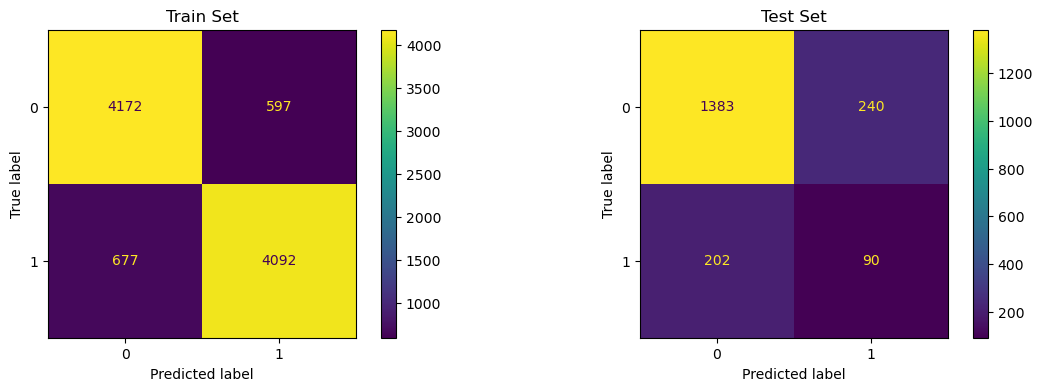

In [17]:
#Reduce features
#lagged_data_MID = lagged_data_MID.drop(column_importance_zero, axis=1)

#Limit time or not?
lagged_data_MID = lagged_data_MID[lagged_data_MID['minutes_lag_avg4'] > 60]

RAND_STATE = 42 # for reproducible shuffling
TT_RATIO = 0.25 # test/train

# X,y
y = lagged_data_MID['return']
X = lagged_data_MID.drop(['return'], axis=1)
#X = X.drop(column_importance_zero, axis=1)

# test-train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)

from imblearn.over_sampling import SMOTE
smote = SMOTE()
#fit training data with upsampling
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts()

from sklearn.ensemble import RandomForestClassifier

#Original rfc
rfc_ops = {"max_depth":6, #Controls depth for all trees
          'max_features': 'sqrt',
          'min_samples_leaf': 1,
          'min_samples_split': 4,
          "n_estimators":200, #number of trees
          "bootstrap":True, #You can disable this if you don't like
          "oob_score":True, #Out of bag score. Use records that weren't already used. Linked to bootstrap
          "random_state":RAND_STATE}

#rfc based on gridsearch
#rfc_ops = {'bootstrap': True,
 #'max_depth': 10,
 #'max_features': 'sqrt',
 #'max_samples': 0.5,
 #'min_samples_leaf': 1,
 #'min_samples_split': 2,
 #'n_estimators': 100,
 #"random_state":RAND_STATE}

clf = RandomForestClassifier(**rfc_ops)

        #max_depth=6,min_samples_leaf=20,max_features=None,n_estimators=100,
         #                    bootstrap=True,oob_score=True, random_state=RAND_STATE)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
print("Decision Tree with Max Depth 6")
performance_log_data = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_train_pred),
                                         precision_score(y_train, y_train_pred, pos_label=1),
                                         recall_score(y_train, y_train_pred, pos_label=1)],
                               'Test': [accuracy_score(y_test, y_test_pred),
                                        precision_score(y_test, y_test_pred, pos_label=1),
                                        recall_score(y_test, y_test_pred, pos_label=1)]})

display(performance_log_data)

from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_confusion_matrix(clf,X_train,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")
plot_confusion_matrix(clf,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

#Cross Validation
from sklearn.model_selection import cross_val_score
folds=3
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=folds)
print("cv scores over {:d} iterations: \n".format(folds))
cross_val_scores


In [ ]:
#Feature importance
feature_names = X_train.columns
df = pd.DataFrame(list(zip(feature_names, clf.feature_importances_)))
df.columns = ['columns_name', 'score_feature_importance']
df.sort_values(by=['score_feature_importance'], ascending = False)
column_importance_zero = df[df['score_feature_importance'] < 0.005]['columns_name'].tolist()
column_importance_zero